In [2]:
# Q-learning 实现
# 悬崖漫步环境下
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [4]:
class CliffWalkingEnv:
    def __init__(self,ncol,nrow):
        self.nrow = nrow
        self.ncol = ncol
        self.col = 0
        self.row = self.nrow - 1

        self.actions = [[0, -1], [0, 1], [-1, 0], [1, 0]] # 上下左右移动
    
    def reset(self):
        self.col = 0
        self.row = self.nrow - 1
        return self.row * self.ncol + self.col

    # agent和环境的交互
    # 要获得next state,对应的reward，要知道是否是最终状态
    def step(self,action):
        self.col = min(self.ncol-1,max(0,self.col + self.actions[action][0]))
        self.row = min(self.nrow-1,max(0,self.row + self.actions[action][1]))

        next_state = self.row * self.ncol + self.col
        reward = -1
        done = False

        if self.row == self.nrow -1 and self.col > 0:
            done = True
            if self.col != self.ncol - 1:
                reward = -100
        
        return next_state, reward,done


In [5]:
class QLearning:
    def __init__(self,ncol, nrow,alpha,gamma,epsilon,n_action = 4) -> None:

        self.n_action = n_action  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        # 这个是行为策略中采用的策略
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数

        self.Q_table = np.zeros([nrow * ncol,self.n_action])
    
    def take_action(self,state):
        '''这个是行为策略下所采取的action,可以看作是采样过程'''
        choose = np.random.random()

        if choose < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        
        return action

    def update(self,s0,a0,r,s1):
        '''更新的输入只需要当前状态，当前行动，对应的reward，和转移状态'''
        # 和SARSA相比不需要下一个状态的动作了
        # 因为计算Q的时候会直接选择 s1状态下最大的Q-value

        Q_real = r + self.gamma * self.Q_table[s1].max()
        Q_old = self.Q_table[s0][a0]
        
        self.Q_table[s0][a0] += self.alpha*(Q_real - Q_old)
    
    def best_action(self,state):
        # 用于后面打印策略
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state][i] == Q_max:
                a[i] = 1
        
        return a

In [8]:
def print_agent(agent, env, action_meaning, disaster=[], end=[]):
    for i in range(env.nrow):
        for j in range(env.ncol):
            if (i * env.ncol + j) in disaster:
                print('****', end=' ')
            elif (i * env.ncol + j) in end:
                print('EEEE', end=' ')
            else:
                a = agent.best_action(i * env.ncol + j)
                pi_str = ''
                for k in range(len(action_meaning)):
                    pi_str += action_meaning[k] if a[k] > 0 else 'o'
                print(pi_str, end=' ')
        print()

In [26]:
# 在悬崖漫步条件下 使用Q-learning算法
np.random.seed(5)

# 定义环境
nrow = 4
ncol = 12
env = CliffWalkingEnv(ncol,nrow)

# 定义agent
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = QLearning(ncol,nrow,alpha,gamma,epsilon,len(env.actions))

num_episodes = 5000

In [28]:
return_list = []

for i in range(10):
    with tqdm(total = int(num_episodes / 10),desc = 'Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            # 对于每一条序列
            # 从最初状态开始
            state = env.reset()
            episode_return = 0
            done = False

            # 开始采样
            while not done:
                # 构造更新的输入
                action = agent.take_action(state)
                next_state,reward,done = env.step(action)

                agent.update(state,action,reward,next_state)
                episode_return += reward # reward没衰减，所以画图应该是不怎么收敛的

                state = next_state
            
            # 一条序列结束
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

Iteration 9: 100%|██████████| 500/500 [00:00<00:00, 5858.78it/s, episode=5000, return=-14.500]


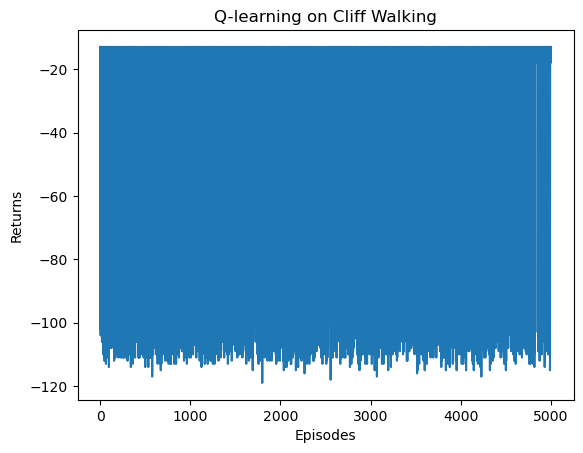

In [29]:
# 画图
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Q-learning on {}'.format('Cliff Walking'))
plt.show()

In [30]:
action_meaning = ['^','v','<','>']
end = [nrow * ncol - 1]
disaster_s = (nrow-1) * ncol + 1
disaster_e = nrow*ncol - 1
disaster = list(range(disaster_s,disaster_e))
print_agent(agent,env,action_meaning,disaster,end)

ovoo ovoo ooo> ooo> ovoo ooo> ooo> ooo> ovoo ooo> ovoo ovoo 
ooo> ooo> ovoo ooo> ooo> ovoo ovoo ovoo ovoo ovoo ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 
